### XGBoost (Regression) Predicting Vehicle Fuel Efficiency

This case demonstrates how XGBoost can be applied in regression problems, highlighting its strength in handling missing values and nonlinear relationships between features and the target variable.

"Fuel efficiency" is a continuous numeric prediction problem and is influenced by multiple features such as vehicle type, weight, and engine size.

In this example, we will use XGBoost to predict fuel efficiency based on tabular data, analyze the model’s performance, and determine which features most significantly impact fuel efficiency.

In [1]:
import pandas as pd

df_data = pd.read_csv('../datasets/auto-mpg.csv')
df_data

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1.0,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1.0,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1.0,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1.0,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1.0,ford torino
...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86,2790,15.6,82,1.0,ford mustang gl
388,44.0,4,97.0,52,2130,24.6,82,2.0,vw pickup
389,32.0,4,135.0,84,2295,11.6,82,1.0,dodge rampage
390,28.0,4,120.0,79,2625,18.6,82,1.0,ford ranger


In [2]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    int64  
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   model year    392 non-null    int64  
 7   origin        392 non-null    float64
 8   car name      392 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 27.7+ KB


#### Count the Number of Cars by Production Region

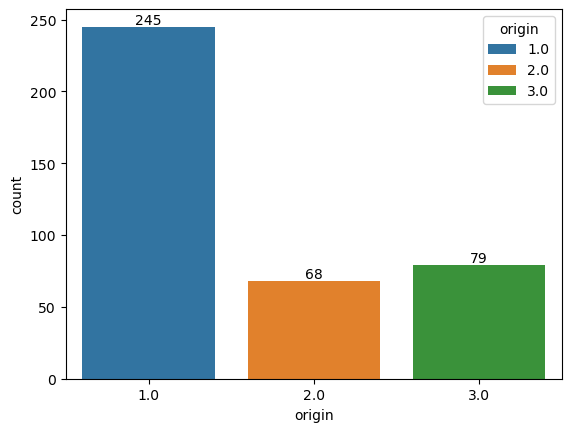

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use seaborn's countplot to draw bar chart
ax = sns.countplot(data=df_data, x='origin', hue='origin', palette='tab10')

# Add labels above each bar
for container in ax.containers:
    ax.bar_label(container)

-   Most cars in the dataset are from the **USA (origin 1)**, with **245 cars**.

-   Cars from **Europe (origin 2)** are the fewest, with only **68 cars**.

-   Cars from **Japan (origin 3)** number **79**.

#### Histogram of Feature Distributions

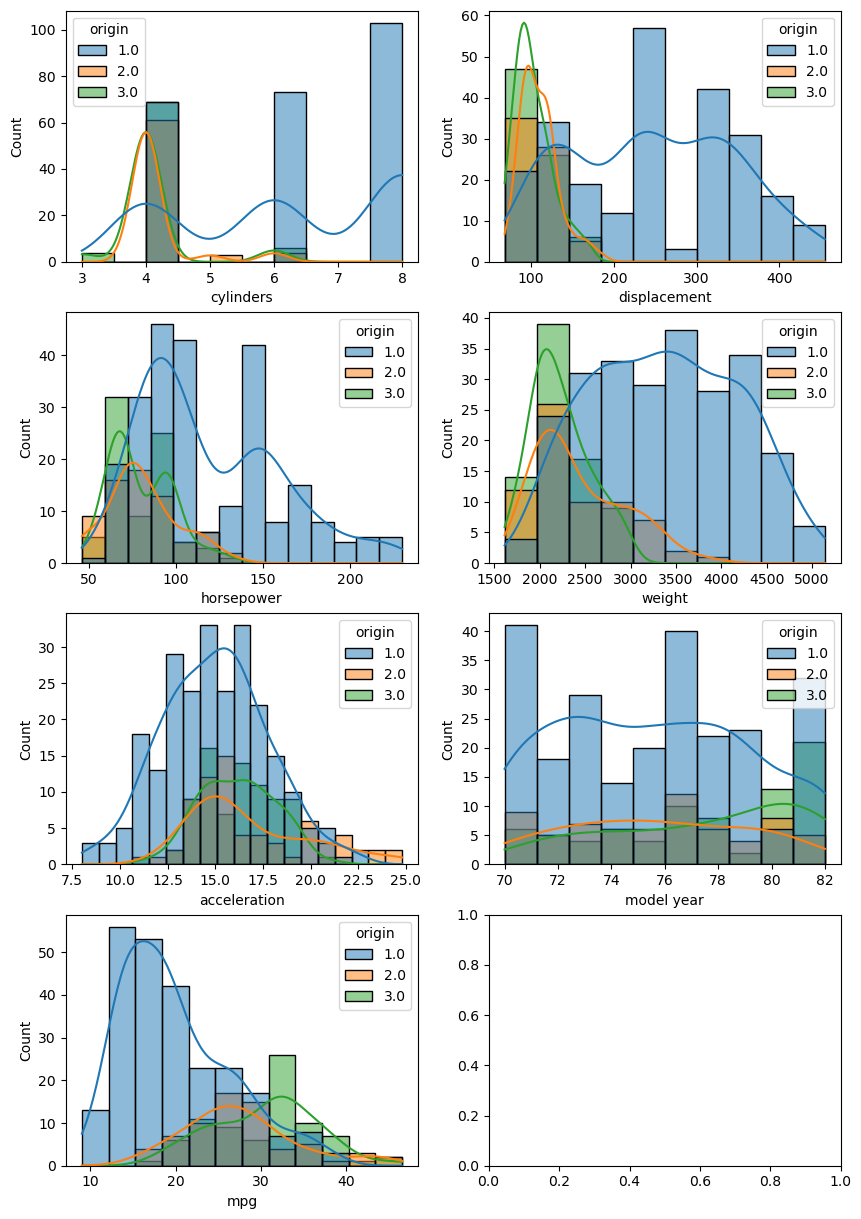

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define feature names
x_feature_names = ['cylinders', 'displacement', 'horsepower', 'weight',
                   'acceleration', 'model year', 'mpg']

# Create subplots
fig, axes = plt.subplots(4, 2, figsize=(10, 15))

# Draw histograms
for ax, name in zip(axes.flatten(), x_feature_names):
    sns.histplot(data=df_data, x=name, hue="origin", kde=True,
                 palette="tab10", ax=ax)


-   **Cylinders**: U.S. cars tend to have 6 or 8 cylinders, while European and Japanese cars mostly have 4, indicating differences in engine design.

-   **Displacement & Horsepower**: U.S. cars have larger displacement and horsepower, while European and Japanese cars are generally lower.

-   **Weight**: U.S. cars are heavier; European and Japanese cars are lighter.

-   **Acceleration**: Acceleration distributions are fairly even across all three regions.

-   **Fuel Efficiency (mpg)**: U.S. cars tend to have lower fuel efficiency, while cars from Europe and Japan generally have higher fuel efficiency.

#### Correlation Heatmap: Visualizing Relationships Between Features

Next, we use a **correlation heatmap** to observe how **fuel efficiency (mpg)** correlates with other input features.

-   First, we use the `.corr()` method to calculate the correlation matrix between `mpg` and other features (e.g., `cylinders`, `displacement`, `horsepower`, `weight`, etc.).

-   To simplify the visualization, we generate a **mask** to hide the upper triangle of the matrix to avoid duplicate display of values.

-   We then use **Seaborn's `heatmap()` function** to visualize the matrix, where the depth of color indicates the strength of correlation.

<Axes: >

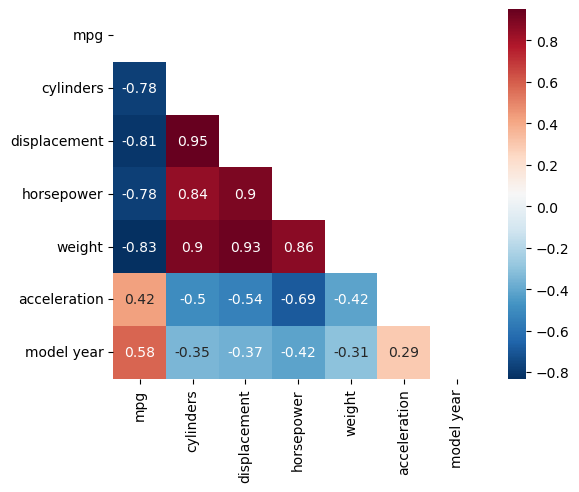

In [5]:
import numpy as np

# Calculate correlation matrix for selected features
corr = df_data[['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
                'acceleration', 'model year']].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot heatmap using seaborn
sns.heatmap(corr, square=True, annot=True, mask=mask, cmap='RdBu_r')


The heatmap shows the **correlation coefficients** between `mpg` and other input features. Darker colors indicate stronger correlations. Some key values:

-   `mpg` has strong **negative correlations** with:

    -   `cylinders` (-0.78)

    -   `displacement` (-0.81)

    -   `horsepower` (-0.78)

    -   `weight` (-0.83)

-   `mpg` has a **positive correlation** with:

    -   `model year` (+0.58)

This reinforces the earlier insight: newer cars tend to be more fuel-efficient, and heavier/more powerful vehicles tend to have lower mpg.

#### Splitting the Dataset into Training and Testing Sets

In [6]:
from sklearn.model_selection import train_test_split

# Define the list of feature names
x_feature_names = ['cylinders', 'displacement', 'horsepower', 'weight',
                   'acceleration', 'model year', 'origin']

# Extract feature values based on column names
X = df_data[x_feature_names].values

# Define the target variable (fuel efficiency)
y = df_data['mpg'].values

# Split the dataset into training and testing sets (90% train, 10% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Display the shapes of the resulting datasets
print('Shape of training set X:', X_train.shape)
print('Shape of testing set X:', X_test.shape)


Shape of training set X: (352, 7)
Shape of testing set X: (40, 7)


-   The dataset is split into **90% training (352 rows)** and **10% testing (40 rows)**.

-   This allows the model to be trained on most of the data while retaining a portion for validating its performance.

#### Building the XGBoost Regression Model

Now that the data is ready, we proceed to **train the model** using XGBoost.

-   We use `XGBRegressor` from the XGBoost library to build the regression model.

-   `n_estimators=10` means we'll build the model using **10 decision trees** (i.e., boosting rounds).

-   This ensemble approach helps **boost prediction accuracy** using multiple weak learners.

-   Training involves calling `.fit()` using `X_train` (features) and `y_train` (targets).

The trained model will then be ready to **predict fuel efficiency (mpg)** based on input features.

In [7]:
from xgboost import XGBRegressor

# Create an XGBRegressor model
xgb_reg = XGBRegressor(n_estimators=10)

# Train the model using the training data
xgb_reg.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=10,
             n_jobs=None, num_parallel_tree=None, ...)

#### Evaluating the Model

In [8]:
from sklearn.metrics import root_mean_squared_error

# Evaluate training set
print("Training Set")
y_train_pred = xgb_reg.predict(X_train)
print("R2 Score:", xgb_reg.score(X_train, y_train))  # Calculate R²
print("RMSE:", root_mean_squared_error(y_train, y_train_pred))  # Calculate RMSE

# Evaluate test set
print("Test Set")
y_test_pred = xgb_reg.predict(X_test)
print("R2 Score:", xgb_reg.score(X_test, y_test))  # Calculate R²
print("RMSE:", root_mean_squared_error(y_test, y_test_pred))  # Calculate RMSE


Training Set
R2 Score: 0.9804346590060213
RMSE: 1.0916009539257558
Test Set
R2 Score: 0.9181013969541822
RMSE: 2.2074935545346843


After completing model training, we use the trained regression model to evaluate its performance. We apply two evaluation metrics:

-   **R² Score**

-   **RMSE (Root Mean Squared Error)**

First, the model makes predictions on the **training set**, and we calculate both the R² score and RMSE to assess how well the model explains the variance and how accurate its predictions are.

Next, we use the **test set** for prediction, and again calculate the R² score and RMSE. These values reflect the model's generalization performance. A good model should maintain similar evaluation scores between training and testing sets, indicating good predictive ability.

#### Model Interpretability

Finally, we can perform feature importance analysis on the well-trained **XGBoost** model and visualize which features have the greatest influence on the prediction results.

First, we access the model's built-in attribute `feature_importances_`, which returns the importance scores for each feature. Then, we sort these scores and visualize them using a **horizontal bar chart** via `matplotlib` to clearly display the importance of each input feature.

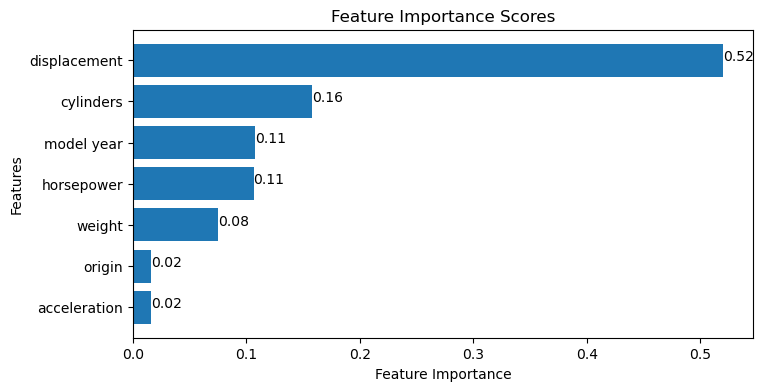

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Get the feature importance scores
importances = xgb_reg.feature_importances_

# Sort indices based on importance values
indices = np.argsort(importances)

# Create a horizontal bar chart
plt.figure(figsize=(8, 4))
bar_plot = plt.barh(range(len(x_feature_names)), importances[indices], align='center')
plt.yticks(range(len(x_feature_names)), [x_feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Scores')

# Show importance values at the end of bars
for rect in bar_plot:
    width = rect.get_width()
    plt.annotate(f'{width:.2f}', xy=(width, rect.get_y() + rect.get_height() / 2))

plt.show()


From the results of the feature importance analysis, we can observe the following key points:

-   **Displacement** is the most important feature. Its influence on the model significantly outweighs other features, with an importance score of **0.52**, indicating a strong impact on predicting fuel efficiency (mpg).

-   **Cylinders** ranks second, with an importance score of **0.16**. This suggests that the number of cylinders also has a noticeable influence on mpg predictions, although it is less impactful than displacement.

-   **Model year** and **horsepower** both have similar importance scores, at **0.11**. This implies that their contributions to the model are modest but still relevant.

-   **Weight** has a slightly lower importance score of **0.08**, but it still contributes to the prediction to some extent.

-   **Origin** and **acceleration** have the lowest importance scores, both at **0.02**, indicating that these features play only a minor role in predicting fuel efficiency.